In [9]:
from preprocessing import *
from pixie_model import *
from evaluation import *

import json
import zipfile
import numpy as np
from collections import Counter
from tqdm import tqdm
import pickle
from sklearn.metrics import roc_auc_score
from sklearn import metrics

VG_path = '/local/scratch/yl535/visualgeno/'
rel_path = VG_path+'relationships.json.zip'
obj_path = VG_path+'objects.json.zip'



## Direct Evaluation


In [10]:
work_path = '/local/scratch/yl535/yl535/'
data_path = '/local/scratch/yl535/yl535/pixie_data/data_pca_2/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
W_mu, W_cov, V = load_trained_model('', device)
predicate_list, predicates_table = generate_vocab(data_path)

x_hidden = pickle.load(open(data_path+"x_preprocessed.p", "rb"))
Y_flat = pickle.load(open(data_path+"y_preprocessed.p", "rb"))
counts = Counter(Y_flat.reshape(-1))


In [4]:
V.shape, torch.det(W_cov),V


(torch.Size([6788, 100]),
 tensor(1.0677, device='cuda:0'),
 tensor([[ 0.2929,  0.2865, -1.1431,  ...,  0.0473, -0.3877, -0.7049],
         [ 0.1457, -1.6808, -0.2598,  ..., -0.0142, -0.4142, -0.9033],
         [ 0.2930, -3.8608,  0.5833,  ...,  0.3298, -0.9070, -1.8438],
         ...,
         [ 1.7473, -2.0623, -0.0653,  ...,  0.1901, -0.5207, -1.2140],
         [ 1.1662, -2.5505, -0.1838,  ...,  0.8056, -0.1847, -0.6962],
         [-0.9271, -3.8653, -0.6586,  ..., -0.0526, -0.3761, -1.0273]],
        device='cuda:0'))

In [6]:
torch.mean(torch.abs(x_hidden)), x_hidden.shape,len(counts)

(tensor(0.9482), torch.Size([1285257, 3, 100]), 6788)

### Lexicon model

In [5]:

# hs = [np.exp(i)/np.exp(9) for i in range(10)]

def roc_cal(word, hs, pixie_pos):
    word_idx = predicates_table[word]
    x_hidden = pickle.load(open(data_path+"x_preprocessed.p", "rb"))
    Y_flat = pickle.load(open(data_path+"y_preprocessed.p", "rb"))

    # positive examples
    positive_examples = x_hidden[np.ix_([word in row for row in Y_flat])][:,pixie_pos][:10000]
    # negative examples
    negative_x = x_hidden[np.ix_([word not in row for row in Y_flat])]
    r=np.random.randint(negative_x.shape[0],size=positive_examples.shape[0])
    negative_examples = negative_x[r, pixie_pos]

    coord = []
    max_f1 = 0
    max_hs = 0
    for h in tqdm(hs):
        tp,fp,fn,tn = 0,0,0,0
        # positive example
        for p in positive_examples:
            if torch.sigmoid(torch.sum(p.to(device)*V[word_idx]))>h:
                tp +=1
            else:
                fn += 1
        # negative example
        for p in negative_examples:
            if torch.sigmoid(torch.sum(p.to(device)*V[word_idx]))>h:
                fp+=1
            else:
                tn +=1
                
        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        f1 = tp/(tp + 0.5*fp + 0.5*fn)
        if f1>max_f1:
            max_f1=f1
            max_hs=h
        
        coord.append([fpr,tpr])
    return coord, [max_f1,max_hs]

def get_roc_score(word, pixie_pos):
    word_idx = predicates_table[word]
    x_hidden = pickle.load(open(data_path+"x_preprocessed.p", "rb"))
    Y_flat = pickle.load(open(data_path+"y_preprocessed.p", "rb"))

    # positive examples
    positive_examples = x_hidden[np.ix_([word in row for row in Y_flat])][:,pixie_pos][:10000]
    # negative examples
    negative_x = x_hidden[np.ix_([word not in row for row in Y_flat])]
    r=np.random.randint(negative_x.shape[0],size=positive_examples.shape[0])
    negative_examples = negative_x[r, pixie_pos]

    y_true = [1]*positive_examples.shape[0] + [0]*negative_examples.shape[0]
    y_predict = []
    for p in positive_examples:
        y_predict.append(torch.sigmoid(torch.sum(p.to(device)*V[word_idx])).cpu().numpy())
    for n in negative_examples:
        y_predict.append(torch.sigmoid(torch.sum(n.to(device)*V[word_idx])).cpu().numpy())
    auc_roc = roc_auc_score(y_true, y_predict)
    return auc_roc, y_true, y_predict

0.7083988800000001
0.7739866863905325
0.6908510279727945
0.7627376948968774
0.7254161235372675
0.7391900238913816
0.533413265
0.5401581900000001


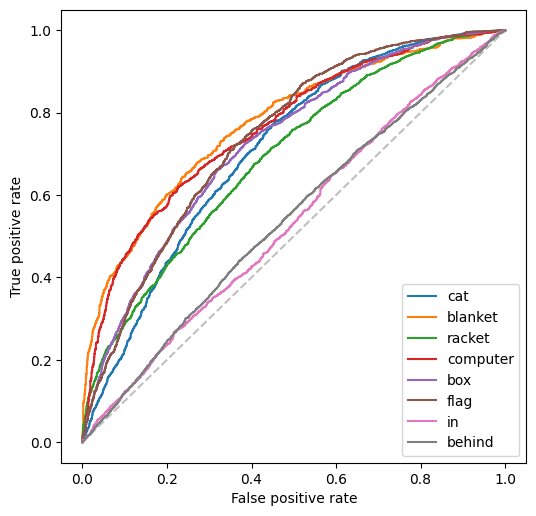

In [25]:
plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')

word_list = ['cat','blanket','racket','computer','box','flag','in','behind']
pos_list = [0,0,0,0,0,0,1,1]
for word,pos in zip(word_list,pos_list):
    auc, y_true, y_predict = get_roc_score(word, pos)
    print(auc)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_predict)
    plt.plot(fpr,tpr)#,drawstyle='steps', label='steps (=steps-pre)')
    
plt.legend(word_list)
plt.plot([0,1],[0,1],'--',alpha=0.5,color='grey')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.savefig('lexicon_graph.pdf')  

plt.show()


### World model

<Figure size 600x600 with 0 Axes>

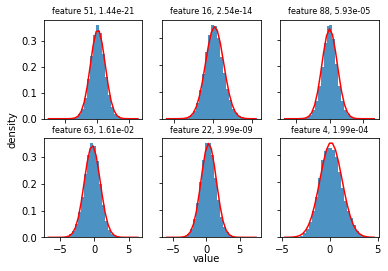

In [35]:
plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')

x_hidden = pickle.load(open(data_path+"x_preprocessed.p", "rb"))
pixie_dim = 100
data = x_hidden.reshape(-1,pixie_dim).numpy()
random_point = np.random.randint(data.shape[0]-100)
data = data[random_point:]

fig, axs = plt.subplots(2, 3)

features = np.random.randint(pixie_dim,size=6)
cnt = 0
for i in range(2):
    for j in range(3):
        k2, p = stats.normaltest(data[:500,features[cnt]])
        _,bins,_ = axs[i, j].hist(data[:,features[cnt]], bins=30,density=1,alpha=0.8)
        axs[i, j].set_title('feature {}, {:.2e}'.format(features[cnt],p),fontsize=8)
        mu, sigma = stats.norm.fit(data[:,features[cnt]])
        best_fit_line = stats.norm.pdf(bins, mu, sigma)
        axs[i, j].plot(bins, best_fit_line,'r')
        axs[i, j].tick_params(axis='both', which='both')
        cnt+=1

for ax in axs.flat:
    ax.label_outer()

fig.text(0.5, 0.04, 'value', ha='center')
fig.text(0.04, 0.5, 'density', va='center', rotation='vertical')
plt.show()




<Figure size 600x400 with 0 Axes>

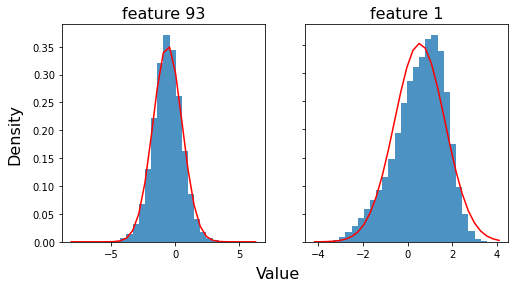

In [7]:

plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

x_hidden = pickle.load(open(data_path+"x_preprocessed.p", "rb"))
pixie_dim = 100
data = x_hidden.reshape(-1,pixie_dim).numpy()
# random_point = np.random.randint(data.shape[0]-100)
# data = data[random_point:]

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(8)
fig.set_figheight(4)

features = [93,1]
cnt = 0
for i in range(1):
    for j in range(2):
        k2, p = stats.normaltest(data[:,features[cnt]])
        _,bins,_ = axs[j].hist(data[:,features[cnt]], bins=30,density=1,alpha=0.8)
        axs[j].set_title('feature {}'.format(features[cnt]),fontsize=16)
        mu, sigma = stats.norm.fit(data[:,features[cnt]])
        best_fit_line = stats.norm.pdf(bins, mu, sigma)
        axs[j].plot(bins, best_fit_line,'r')
        axs[j].tick_params(axis='both', which='both')
        cnt+=1

for ax in axs.flat:
    ax.label_outer()

fig.text(0.5, 0, 'Value', ha='center',fontsize=16)
fig.text(0.03, 0.5, 'Density', va='center', rotation='vertical',fontsize=16)
plt.savefig('world_graph.pdf')  

plt.show()

In [7]:

x_hidden = pickle.load(open(data_path+"x_preprocessed.p", "rb"))
pixie_dim = 100
data = x_hidden.reshape(-1,pixie_dim).numpy()

bins = np.linspace(-10, 10, 50)
errors = []

for feature_dim in range(100):
    digitized = np.digitize(data[:,feature_dim], bins)
    mu, sigma = stats.norm.fit(data[:,feature_dim])
    best_fit_line = stats.norm.pdf(bins, mu, sigma)
    # print(digitized)
    counts = Counter(digitized)
    total = digitized.shape[0]
    s_fit = 0
    s_hist = 0 
    density_record = []
    error = 0
    for i in range(len(bins)):
        edge = bins[i]
        density = counts[i]/total if i in counts else 0
        density_record.append(density)
        s_hist = edge * density
        s_fit += edge * best_fit_line[i]/np.sum(best_fit_line)
        error += max(density-best_fit_line[i]/np.sum(best_fit_line),0)
        # error += np.abs(density-best_fit_line[i]/np.sum(best_fit_line))
        # print(density, best_fit_line[i]/np.sum(best_fit_line),error)
    # assert False
    print(error)
    errors.append(error)

np.mean(errors), np.std(errors)

0.15307026447872155
0.13765402501604745
0.09404001591164343
0.0995866928585654
0.08583745926788977
0.05289865285990252
0.07195873315754377
0.07297636911970029
0.07369148380286471
0.06788071537146768
0.09177227081020474
0.07288283871694136
0.08030784438891135
0.0708411510423859
0.07345364482208619
0.07098631898044676
0.06237390208163831
0.08166468774292054
0.062341437551389205
0.07066562104859825
0.06564826743730065
0.07166487616194578
0.07827369624175735
0.06889024335281355
0.0755437843698188
0.08660897427782624
0.07878474384420031
0.08125861085263013
0.07032176765184718
0.07049767252532907
0.07388681510455453
0.06705361447456938
0.08000500744746333
0.07228270750822748
0.0831936510877205
0.0773988869133718
0.07337475420122083
0.08238484302968302
0.07187412208323254
0.07080612058847653
0.07554920570910775
0.07218980399784745
0.0733715545359172
0.09045052559856329
0.07214751137154192
0.08429994719119181
0.06754961352483273
0.07166734597572215
0.06464316126495845
0.07674320544623772
0.072

(0.07764512560010331, 0.01186395185566351)

In [8]:
np.sum(best_fit_line), np.sum(density_record), error
# best_fit_line

(2.4499999999999997, 1.0, 0.07524252681583697)

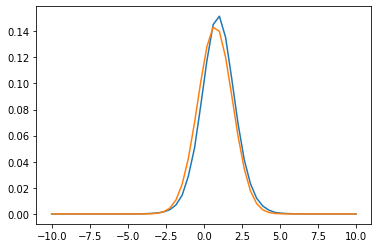

In [9]:
plt.plot(bins,density_record)
plt.plot(bins,best_fit_line/np.sum(best_fit_line))
# plt.plot(bins,(density_record-(best_fit_line/np.sum(best_fit_line))))

### Further lexicon model evaluation

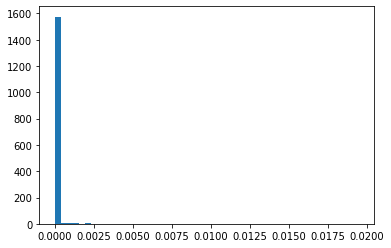

shoe
truth  0.019510655
ranking:  0
----------------------------
close words: 
shirt 0.0012058653
short_pants 0.0013821324
bat 0.0014083995
sock 0.0016960171
cleat 0.0019796018
helmet 0.0020090127
hand 0.002332214
hat 0.0024389904
foot 0.006873425
shoe 0.019510625


In [12]:
random_pixie = np.random.randint(x_hidden.shape[0])
pos=0
pixie = x_hidden[random_pixie,pos,:]
all_truths = torch.sigmoid(torch.matmul(pixie.to(device), V.t())).cpu().numpy()
plt.hist(all_truths,bins=50)
plt.show()
print(Y_flat[random_pixie,pos])
print('truth ',torch.sigmoid(torch.matmul(pixie.to(device), V[predicates_table[Y_flat[random_pixie,pos]]].t())).cpu().numpy())
rank = np.where(all_truths.argsort()[::-1]==predicates_table[Y_flat[random_pixie,pos]])[0].item()
print('ranking: ',rank)
print('----------------------------')
print('close words: ')
for word, truth in zip([predicate_list[i] for i in all_truths.argsort()[-10:]], sorted(all_truths)[-10:]):
    print(word,truth)


In [ ]:
torch.min(V)

tensor(-6.7867, device='cuda:0')

## lexicon model apply to inferred pixies 

In [33]:

def _single_variational_inference(pred,pos,W_mu, W_cov, V, device):
    pixie_dim, lr, epoch_num = 100, 0.03,  800

    if not isinstance(pred,list):
        model = VariationalInferenceModel(pixie_dim)   # here depends on the dataset
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-7, max_lr=lr,step_size_up=100,mode="triangular2",cycle_momentum=False)
        loss_history = []
        for epoch in range(epoch_num):
            q_mu, q_cov = model()
            optimizer.zero_grad()
            W_mu_pos = W_mu[pixie_dim*pos:pixie_dim*(pos+1)]
            W_cov_pos = W_cov[pixie_dim*pos:pixie_dim*(pos+1),pixie_dim*pos:pixie_dim*(pos+1)]
            Dqp = -torch.log(torch.det(q_cov))  \
                + torch.sum(torch.mul((q_mu-W_mu_pos).T, torch.matmul(torch.inverse(W_cov_pos),(q_mu-W_mu_pos).T))) \
                + torch.sum(torch.diagonal(torch.matmul(torch.inverse(W_cov_pos), q_cov),dim1=-1, dim2=-2))
            
            pred_loss = approx_E_log_sig(q_mu, q_cov, torch.unsqueeze(V[pred],0)) \
                        - torch.log(torch.sum(approx_E_sig(q_mu, q_cov, V)))
        
            loss = 0.1*Dqp - pred_loss
            loss.backward()
            optimizer.step()  
            scheduler.step()
            loss_history.append(loss.item())
        print(Dqp.item(), pred_loss.item())
        all_truths = approx_E_sig(q_mu, q_cov, V).cpu().detach()
        return all_truths, loss_history
    else:
        model = VariationalInferenceModel(pixie_dim*3)   # here depends on the dataset
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.05)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-5, max_lr=lr,step_size_up=300,mode="triangular2",cycle_momentum=False)
        loss_history = []
        for epoch in range(epoch_num):
            q_mu, q_cov = model()
            optimizer.zero_grad()
            # W_mu_pos = W_mu[pixie_dim*pos:pixie_dim*(pos+1)]
            # W_cov_pos = W_cov[pixie_dim*pos:pixie_dim*(pos+1),pixie_dim*pos:pixie_dim*(pos+1)]
            Dqp = -torch.log(torch.det(q_cov)) \
                + torch.sum(torch.mul((q_mu-W_mu).T, torch.matmul(torch.inverse(W_cov),(q_mu-W_mu).T))) \
                + torch.sum(torch.diagonal(torch.matmul(torch.inverse(W_cov), q_cov),dim1=-1, dim2=-2))
            pred_loss = 0
            for i in range(len(pred)):
                q_mu_pos = q_mu[pixie_dim*i:pixie_dim*(i+1)]
                q_cov_pos = q_cov[pixie_dim*i:pixie_dim*(i+1),pixie_dim*i:pixie_dim*(i+1)]
                pred_loss += approx_E_log_sig(q_mu_pos, q_cov_pos, torch.unsqueeze(V[pred[i]],0)) \
                            - torch.log(torch.sum(approx_E_sig(q_mu_pos, q_cov_pos, V)))
        
            loss = 0.1*Dqp - pred_loss
            loss.backward()
            optimizer.step()  
            scheduler.step()
            loss_history.append(loss.item())
            if epoch%500 == 0:
                print(Dqp.item(), pred_loss.item())
                print(torch.sum(torch.mul((q_mu-W_mu).T, torch.matmul(torch.inverse(W_cov),(q_mu-W_mu).T))).item())

        q_mu_pos = q_mu[pixie_dim*pos:pixie_dim*(pos+1)]
        q_cov_pos = q_cov[pixie_dim*pos:pixie_dim*(pos+1),pixie_dim*pos:pixie_dim*(pos+1)]
        all_truths = approx_E_sig(q_mu_pos, q_cov_pos, V).cpu().detach()
        return all_truths, loss_history
    
    

In [ ]:
# pred = np.random.randint(len(predicate_list))
# pred=1084
pred = predicates_table['computer']

112.45112609863281 -7.300915718078613
rank:  0
word chosen:  animal truth:  0.5387191
--------------------------------------
horn 0.27492386
sheep 0.29656908
leg 0.31263813
ear 0.31342313
elephant 0.32640228
bear 0.34492534
head 0.35379434
cow 0.36112076
horse 0.39147493
animal 0.5387191


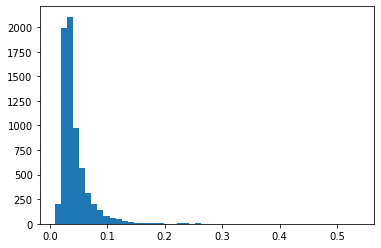

In [27]:
pred = predicates_table['animal']
pos = 2
cnt = 0
rank = 101
while cnt<3 and rank >50:
    cnt+=1
    all_truths, loss_history = _single_variational_inference(pred, pos, W_mu, W_cov, V, device)
    all_truths = all_truths.numpy()
    rank = np.where(all_truths.argsort()[::-1]==pred)[0].item()
    print('rank: ',rank)

print('word chosen: ', predicate_list[pred],'truth: ', all_truths[pred])
print('--------------------------------------')
for word, truth in zip([predicate_list[i] for i in all_truths.argsort()[-10:]], sorted(all_truths)[-10:]):
    print(word,truth)

plt.hist(all_truths,bins=50)
plt.show()



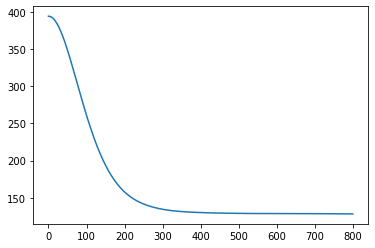

In [18]:
plt.plot(loss_history)


1141.508056640625 -36.79842758178711
509.4943542480469
400.47161865234375 -20.954044342041016
36.34983444213867
rank:  0
word chosen:  horse   truth:  0.41288185
word chosen:  bear   truth:  0.3618746
--------------------------------------
sheep 0.3174265
ear 0.34123814
giraffe 0.3428861
bear 0.3618746
cow 0.37209982
elephant 0.3744392
leg 0.37569532
head 0.3841685
horse 0.41288185
animal 0.55603194


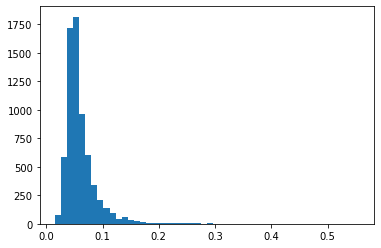

In [34]:
triple = ['animal','has','tail']
pred = [predicates_table[w] for w in triple]
pos = 0
cnt = 0

rank = 101
while cnt<3 and rank >50:
    cnt+=1
    all_truths, loss_history = _single_variational_inference(pred, pos, W_mu, W_cov, V, device)
    all_truths = all_truths.numpy()
    rank = np.where(all_truths.argsort()[::-1]==pred[pos])[0].item()
    print('rank: ',rank)

test_word = 'horse'
print('word chosen: ', test_word,'  truth: ', all_truths[predicates_table[test_word]])

test_word = 'bear'
print('word chosen: ', test_word,'  truth: ', all_truths[predicates_table[test_word]])
print('--------------------------------------')
for word, truth in zip([predicate_list[i] for i in all_truths.argsort()[-10:]], sorted(all_truths)[-10:]):
    print(word,truth)

plt.hist(all_truths,bins=50)
plt.show()




1007.3828735351562 -32.65751266479492
355.14691162109375
401.52252197265625 -21.099214553833008
34.78834533691406
rank:  0
word chosen:  horse   truth:  0.38039127
word chosen:  bear   truth:  0.43033195
--------------------------------------
dog 0.34171307
leg 0.3450203
elephant 0.35226455
cat 0.35651007
cow 0.3671985
ear 0.375117
horse 0.38039127
head 0.4268865
bear 0.43033195
animal 0.5669627


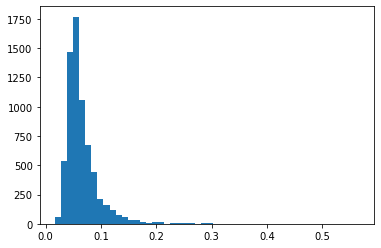

In [35]:
triple = ['animal','has','paw']
pred = [predicates_table[w] for w in triple]
pos = 0
cnt = 0

rank = 101
while cnt<3 and rank >50:
    cnt+=1
    all_truths, loss_history = _single_variational_inference(pred, pos, W_mu, W_cov, V, device)
    all_truths = all_truths.numpy()
    rank = np.where(all_truths.argsort()[::-1]==pred[pos])[0].item()
    print('rank: ',rank)

test_word = 'horse'
print('word chosen: ', test_word,'  truth: ', all_truths[predicates_table[test_word]])

test_word = 'bear'
print('word chosen: ', test_word,'  truth: ', all_truths[predicates_table[test_word]])
print('--------------------------------------')
for word, truth in zip([predicate_list[i] for i in all_truths.argsort()[-10:]], sorted(all_truths)[-10:]):
    print(word,truth)

plt.hist(all_truths,bins=50)
plt.show()

In [ ]:
# all_truths
def _get_ranking(all_truths, pred_list, pred):
    sorted_truth = np.sort(all_truths)
    truth_index = np.argsort(all_truths)
    cnt=0
    for t, i in zip(sorted_truth,truth_index):
        if i in pred_list:
            cnt+=1
        if i ==pred:
            return cnt
_get_ranking(all_truths, [1,2,3,4,5,6,7], 1)

4

In [41]:

def features_PCA(data_path, pca_path,pixie_dim_new):
    pixie_dim = 1000
    # cov_global = torch.zeros(pixie_dim,pixie_dim)
    data_size = 0
    batch_number = 10
    x_batch, y_batch = [], []
    for itr in tqdm(range(batch_number)):
        x_hidden = pickle.load(open(data_path+"x_{}.p".format(itr), "rb")).reshape(-1, pixie_dim)
        Y_flat = pickle.load(open(data_path+"y_{}.p".format(itr), "rb"))
        x_batch.append(x_hidden)
        y_batch.append(Y_flat)

    x_batch = torch.cat(x_batch)
    y_batch = np.concatenate(y_batch)

    # x_batch = (x_batch-torch.mean(x_batch,0))/torch.std(x_batch,0)
    cov = np.cov(x_batch.T)

    eigen_values, eigen_vectors = np.linalg.eig(cov)
    projection_matrix = (eigen_vectors.T[:][:pixie_dim_new]).T
    X_pca = x_batch.numpy().dot(projection_matrix) /pow(eigen_values[:pixie_dim_new],1/2) *1.16

    # further rescaling the data so that the covariance will have diagonal entries close to 1 and therefore det close to 1
    # need to recompute the eigenvalues
    # cov = get_cov(torch.Tensor(X_pca))
    # w, _ = np.linalg.eig(cov)
    # X_pca = X_pca * np.sqrt(w)/np.product(np.array([pow(e,1/pixie_dim) for e in w]))

    pickle.dump(torch.Tensor(X_pca).reshape(-1,3,pixie_dim_new), open(pca_path+"x_preprocessed.p", "wb"))
    pickle.dump(y_batch, open(pca_path+"y_preprocessed.p", "wb"))

def get_cov(x):
    mu = torch.mean(x,0)
    cov = torch.matmul((x-mu).T,(x-mu))/x.shape[0]
    return cov


In [42]:
features_PCA('/local/scratch/yl535/pixie_data_2/', '/local/scratch/yl535/pixie_data_2/data_pca_2/', 100)













100%|██████████| 10/10 [00:20<00:00,  2.04s/it]


In [ ]:
# x_batch = torch.Tensor(X_pca)
sum(eigen_values[:100])/sum(eigen_values)

0.9321863318924608

In [39]:
x_batch =X_pca/pow(eigen_values[:100],1/2) *1.16

In [ ]:
x_batch = X_pca * np.sqrt(eigen_values[:100])/np.product(np.array([pow(e,1/pixie_dim) for e in eigen_values[:100]]))

<ipython-input-98-4ac0e935379c>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(softmax(x_hidden[idx]))


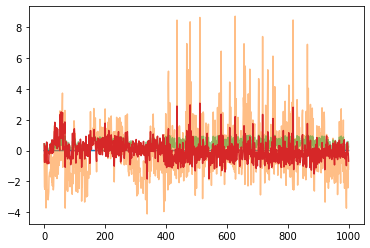

In [ ]:
idx=15
softmax = torch.nn.Softmax()
plt.plot(softmax(x_hidden[idx]))
plt.plot(x_hidden[idx],alpha=0.5)
plt.plot(torch.sigmoid(x_hidden[idx]), alpha=0.5)
x_hidden.shape,
plt.plot((x_hidden[idx]-torch.mean(x_hidden,0))/torch.std(x_hidden,0))


In [40]:
# used to adjust the rescale coefficent
# x_batch = pickle.load(open('/local/scratch/yl535/pixie_data_2/data_pca_2/'+"x_preprocessed.p", "rb"))
pixie_dim=100
x_batch = torch.Tensor(x_batch)
x = x_batch.reshape(-1,3,pixie_dim).reshape(-1,3*pixie_dim)
world = WorldModel(pixie_dim,2)
world.estimate_parameters(x)
world.modify_conditional_independecy()
torch.det(world.W_cov)

tensor(0.5048)

In [20]:
torch.mean(torch.abs(x_batch)), torch.max(x_batch) ,torch.min(x_batch)

(tensor(1.0188), tensor(8.5408), tensor(-9.0616))

In [80]:
model = models.resnet101(pretrained=True)
resnet = torch.nn.Sequential(*(list(model.children())[:-1]))


In [8]:
y_true = [0,0,1,0,0]
y_scores = [0.8,0.9,0.7,0.2,0.5]
metrics.average_precision_score(y_true, y_scores)

0.3333333333333333

In [9]:
a = [1,2,3]
b = [['a','b','c'],['b','c','d'],['c','d','e']]
for i,j in zip(a,b):
    print(i,j)

1 ['a', 'b', 'c']
2 ['b', 'c', 'd']
3 ['c', 'd', 'e']
